# Quantum Variational Monte Carlo Ising model in 1D using Stochastic Reconfiguration

In this notebook we will try to find the optimal parameters of a trial wavefunction describing the 1D quantum Ising model with varying number of spins. The trial wavefunction has an RBM-like expression:
$$
    \Psi(\mathcal{S}) = e^{b^Ts}\prod_{i=1}^{n_h}2\cosh(c_i + W^T_is)
$$
where $n_h$ is the number of hidden units, and $\mathbf{\theta} = \{\mathbf{b},\mathbf{c},\textbf{W}\}$ are our variational parameters. According to the variational method, this wavefunction will provide an upper bound to the ground state energy that we are trying to estimate:
$$
    E = \frac{\langle\Psi|\hat{H}|\Psi\rangle}{\langle\Psi|\Psi\rangle}
$$
where the Hamiltonian of the Transverse Field Ising model is:
$$
    \hat{H} = -J\sum_{i=1}^{N}\hat{\sigma}^z_i\hat{\sigma}^z_{i+1} -B\sum_{j=1}^N\hat{\sigma}^x_j
$$
with periodic boundary conditions: $\hat{\sigma}^z_L\hat{\sigma}^z_{L+1} \equiv \hat{\sigma}^z_L\hat{\sigma}^z_1$, and $\hat{\sigma}^z,\hat{\sigma}^x$ being the Pauli matrices acting on the spins, $J,B$ the coupling and the transverse magnetic field term, respectively.

## Statistical Analysis and Autocorrelation Time

Measurements in Markov chains are usually correlated to a certain degree. Though, correlation fades as the number of steps between measured states increases. The distance at which we can consider that two states are uncorrelated is called the **autocorrelation time** $\tau$. However, finding the value analytically is too difficult, so we rely in the binning analysis of the time series to estimate $\tau$.

### Binning Analysis

Assume that we do not have any prior knowledge about the autocorrelation time. Then, we have to use $N_B$ blocks of the time-series samples of increasing lengths $k=2^0,2^1,2^2,\ldots$ until the error estimate for the block converges:
$$
    \varepsilon \approx \sqrt{\frac{s^2_B}{N_B}},\quad\text{where}\quad s^2_B = \frac{1}{N_B-1}\sum_{i=1}^{N_B}(\langle f\rangle_{B_i} - \langle f\rangle_B)^2
$$
The $i$-th block average is computed as
$$
    \langle f\rangle_{B_i} = \frac{1}{k}\sum_{t=1}^kf(x_{(i-1)k+t})
$$
and the mean of all the block averages is
$$
    \langle f\rangle_B = \frac{1}{N_B}\sum_{i=1}\langle f\rangle_{B_i}
$$

The integrated autocorrelation time can be inferred from the binning analysis results. Being
$$
    \tau = \frac{1}{2}\frac{\frac{s^2_B}{N_B}(k\to\infty)}{\frac{s^2_B}{N_B}(k=1)}
$$

## Stochastic Reconfiguration

In order to find the optimal configuration of parameters which minimizes the energy, we will use stochastic reconfiguration of the gradients:
 - Starting from a random initial configuration of the parameters.
 - Proposing a new state $s\to s'$.
 - Accepting the change with probability $|\Psi(s')|^2/|\Psi(s)|^2$.
 - Updating the parameters in our wavefunction as follows:
$$
    \theta^{(t+1)}_k = \theta^{(t)}_k - \delta t\textbf{S}^{-1}\textbf{F}
$$
where we define $\textbf{S}$ as the Fubini-Study metric information matrix
$$
    S_{kk'} = \langle\Delta^*_k\Delta_{k'}\rangle - \langle\Delta^*_k\rangle\langle\Delta_{k'}\rangle
$$
to which we can add an extra regularization term to increase stability, by removing the null diagonal terms $S_{kk} \leftarrow S_{kk} + \lambda$. We also define $\Delta_k$ as the log-derivative of the k-th parameter, and $\textbf{F}$ as the gradient of the mean energy
$$
    F_k = \langle E_{\text{loc}}\Delta^*_k\rangle - \langle E_{\text{loc}}\rangle\langle\Delta^*_k\rangle
$$
To find the ground state of the Hamiltonian, we need to calculate the variational derivatives of the parameters in our RBM ansatz:
$$
    \Delta_{b_j}(s) = \frac{\partial}{\partial b_j}\log(\Psi(s)) = s_j
$$
$$
    \Delta_{c_i}(s) = \frac{\partial}{\partial c_i}\log(\Psi(s)) = \tanh(c_i + \sum_{j=1}^{N}\omega_{ij}s_j)
$$
$$
    \Delta_{\omega_{ij}}(s) = \frac{\partial}{\partial \omega_{ij}}\log(\Psi(s)) = s_j\tanh(c_i + \sum_{j=1}^{N}\omega_{ij}s_j)
$$

### Libraries

In [1]:
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm import tqdm

### RBM Class Definition

In [2]:
class RBM:
    def __init__(self, num_visible, num_hidden, sigma=0.01):
        self.n_visible = num_visible
        self.n_hidden = num_hidden
        self.initialise_parameters(sigma)

    def initialise_parameters(self,sigma):
        ## Initializes parameters as random complex valued gaussians
        b = np.random.randn(self.n_visible) + 1j*np.random.randn(self.n_visible)
        c = np.random.randn(self.n_hidden) + 1j*np.random.randn(self.n_hidden)
        W = (np.random.randn(self.n_hidden,self.n_visible) + 
                1j*np.random.randn(self.n_hidden,self.n_visible))
        self.params = sigma*np.concatenate((b,c,W.ravel()))

    # Define b, c, W as properties in order to avoid accidentally modifying them
    # while getting their values
    @property
    def b(self):
        return self.params[:self.n_visible]

    @property
    def c(self):
        return self.params[self.n_visible:self.n_visible+self.n_hidden]

    @property
    def W(self):
        return np.reshape(self.params[self.n_visible+self.n_hidden:], 
                          (self.n_hidden, self.n_visible))

    def wavefunction(self,s):
        ## Projection of the wavefunction onto state s
        p = np.exp(self.b @ s)*np.prod(np.cosh(self.c + self.W @ s))*2**self.n_hidden
        return p
    
    def p_ratio(self, s1, s2):
        ## Probability ratio between state s2 and reference state s1
        p1 = np.cosh(self.c + self.W @ s1)
        p2 = np.cosh(self.c + self.W @ s2)
        log_diff = self.b @ (s2 - s1) + sum(np.log(p2/p1)) # log of ratio for numerical stability
        return np.exp(log_diff)
        
    def p_ratios(self, s1, s2):
        ## Probability ratios between list of states s2 and reference state s1
        return [self.p_ratio(s1, s) for s in s2]

### Useful Functions

In [3]:
def local_energy(s, psi, pbc=True,J=2,B=1):
    ## Local energy of TFI model
    # Interaction term
    couplings = (s[:-1]==s[1:])*2-1
    e_interaction = -J*sum(couplings)

    # Add Periodic Boundary Conditions
    if pbc:
        e_interaction -= J*((s[-1]==s[0])*2-1)
    
    # Transverse field
    states_with_flip = [flip(s, i) for i in range(len(s))]
    e_field = -B*sum(psi.p_ratios(s, states_with_flip))

    return e_interaction + e_field 
    
def flip(s, i):
    ## Flips i-th spin of state s
    s_flip = deepcopy(s)
    s_flip[i] = 1 - s_flip[i]
    return s_flip

def bin_averages(x,block_size):
    ## Bins time-series x into bs chunks and takes means
    N_B = len(x)//block_size
    bin_avg = [np.mean(x[block*block_size:(block+1)*block_size]) for block in range(N_B)]
    return np.array(bin_avg)

def variational_derivative(s, psi):
    ## Variational log-derivatives for SR
    theta = psi.c + psi.W @ s
    Ob = s
    Oc = np.tanh(theta)
    Ow = Oc[:, None] @ s[None, :]
    return np.concatenate((Ob, Oc, Ow.ravel()))

def covariance(s1, s2):
    ## Computes the covariance between states s1 and s2.
    samples = s1.shape[1]
    m1 = np.mean(s1, axis=1)
    m2 = np.mean(s2, axis=1) if len(s2.shape)>1 else np.mean(s2)
    return (s1 @ s2.T)/samples - m1[:,None] @ m2[None,:]

def sample_block(psi, block_size, s0=None, n_flips=1):
    ## Sample block_size states according to psi.
    state = np.random.randint(0, 2, psi.n_visible) if s0 is None else s0
    states = []
    for _ in range(block_size):
        spin_idx = np.random.randint(0, psi.n_visible, n_flips)
        new_state = flip(state, spin_idx)
        if np.random.random() <= np.abs(psi.p_ratio(state, new_state))**2:
            state = deepcopy(new_state)   # Accept new state   
        states.append(state)
    return states

def PauliMatrices():
    # Return the Pauli matrices spin operators
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_z = np.array([[1, 0], [0, -1]])
    return sigma_x, sigma_z

def eye(n):
    # Calculate the identity matrix for a given number of spins
    if n == 0:
        return 1
    if n == 1:
        return np.array([[1, 0], [0, 1]])
    elif n % 2 == 0:
        m = n//2
        return np.kron(eye(m),eye(m))
    else:
        m = n//2
        return np.kron(np.kron(eye(m),eye(m)),eye(1))

def Hamiltonian(N, J, B):
    sigma_x, sigma_z = PauliMatrices()
    H = np.zeros((2**N, 2**N))
    for i in range(N-1):
        H -= J*np.kron(eye(i),np.kron(sigma_z,np.kron(sigma_z,eye(N-i-2))))
    for i in range(N):
        H -= B*np.kron(eye(i),np.kron(sigma_x,eye(N-i-1)))
    # Add boundary conditions
    if N >= 2:
        H -= J*np.kron(sigma_z,np.kron(eye(N-2),sigma_z))
    return H

def diagonalizeHamiltonian(H,print_output=False):
    # The exact solutions of the eigenvalue problem
    eigenvalues, eigenvectors = eigh(H)
    eigenvectors = np.transpose(eigenvectors)
    
    # Print eigenvalues
    if print_output:
        for i in range(len(eigenvalues)):
            print("Eigenvalue:",eigenvalues[i])
            print("Eigenvectors:")
            print(eigenvectors[i])
            print("\n")
    return eigenvalues, eigenvectors

### Example: Monte Carlo RBM wavefunction

In [4]:
np.random.seed(7) # Lucky number

# Number of spins
n = 4

# Hamiltonian terms
J, B = 2, 1

# Initialising RBM
n_visible, n_hidden = n, 2*n
psi = RBM(n_visible, n_hidden, sigma=0.1)

We can see that the squared error converges for a bin size of $\sim100$. When the bin size is too large, the number of blocks in which we can divide our time-series becomes too small and that leads to statistical fluctuations.

Also, flipping only one spin at each iteration implies that for low number of spins (e.g., $n = 2-4$), the autocorrelation between one state and the next is much lower than flipping only one spin for large number of spins (e.g., $n = 20$). In other words, this calculation (or its estimation) only makes sense for $n$ sufficiently large.

In [5]:
# Parameters for Stochastic Reconfiguration
learning_iterations = 375
lr = 1e-2
n_blocks = 150
thermalise = int(0.1*n_blocks)
N_B = n_blocks - thermalise
block_size = 10
n_flips = 1
energies = []

for it in tqdm(range(learning_iterations)):
    EL, O = np.zeros(N_B, dtype=complex), np.zeros((len(psi.params), N_B), dtype=complex)
    states = sample_block(psi, thermalise*block_size, n_flips=n_flips)
    state = states[-1]
    for k in range(N_B):
        batch = sample_block(psi, block_size, s0=state, n_flips=n_flips)
        states += batch
        state = batch[-1]
        EL[k] = local_energy(state, psi,J=J,B=B)
        O[:, k] = variational_derivative(state, psi)
    
    energies.append(EL.mean())
    F = covariance(O.conj(), EL[None,:])   # Gradient
    S = covariance(O.conj(), O)            # Fisher info
    Sinv = np.linalg.pinv(S, rcond=1e-5)   # (pseudo)Inversion
    d_params = lr*Sinv @ F
    psi.params -= d_params.squeeze()

100%|████████████████████████████████████████████████████████████████████████████████| 375/375 [00:38<00:00,  9.65it/s]


### Energy evolution plot

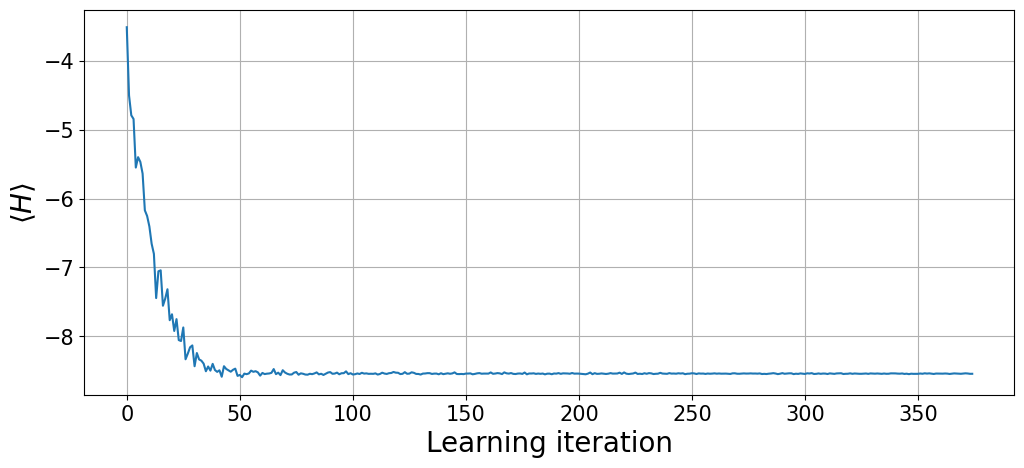

In [6]:
plt.figure(figsize=(12, 5))
plt.plot(np.real(energies))
plt.grid()
plt.tick_params(labelsize=15)
plt.ylabel(r"$\langle H\rangle$", fontsize=20)
plt.xlabel("Learning iteration", fontsize=20);

### Energy samples

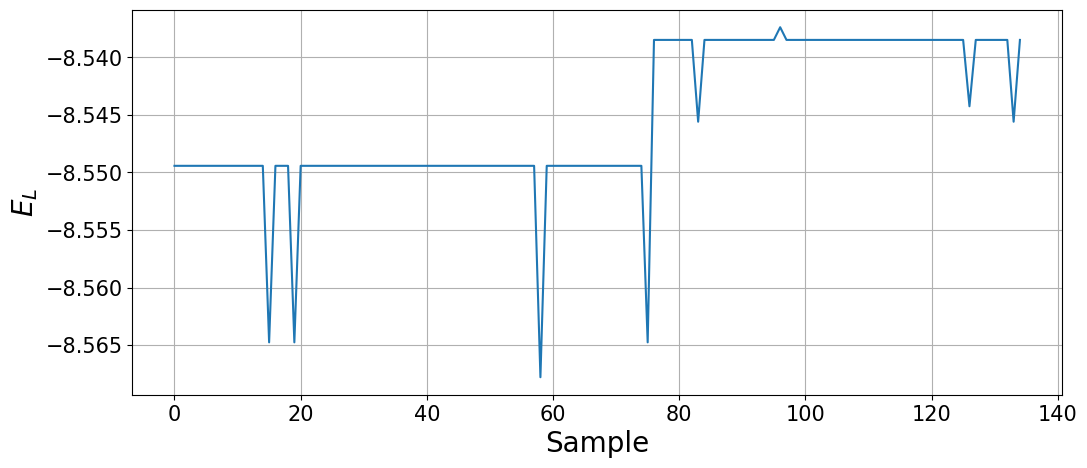

In [7]:
plt.figure(figsize=(12, 5))
plt.plot(np.real(EL))
plt.grid()
plt.tick_params(labelsize=15)
plt.ylabel(r"$E_L$", fontsize=20)
plt.xlabel("Sample", fontsize=20);

In [8]:
bins = 100
energy = np.mean(np.real(energies[-bins:]))
statistical_error = np.std(energies[-bins:])/np.sqrt(bins)
print(f"The obtained energy is {energy:.6f}+-{statistical_error:.6f}")

The obtained energy is -8.542929+-0.000351


### Exact ground state and energy

In this case, we can diagonalize the Hamiltonian to obtain both the ground state and its eigenenergy.

In [9]:
H = Hamiltonian(n,J,B)
# Compare with real ground state energy
eigenenergies, eigenvectors = diagonalizeHamiltonian(H)

print("Exact Energy: %.6f" % np.real(eigenenergies[0]))
print("Error: %.5f" % np.real((eigenenergies[0] - energy)/eigenenergies[0]*100))

Exact Energy: -8.543117
Error: 0.00220


### Magnetization of the ground state

We can compare the (longitudinal/transversal) magnetization of the exact ground state with the mean of the sampled state found with Stochastic Reconfiguration. For that, we simply calculate
$$
    m_z = \sqrt{\langle(\hat{\sigma}^z)^2\rangle} = \sqrt{\langle\psi_0|(\tfrac{1}{N}\textstyle\sum_{i=1}^N\hat{\sigma}^z_i)^2|\psi_0\rangle}
$$
$$
    m_x = \sqrt{\langle(\hat{\sigma}^x)^2\rangle} = \sqrt{\langle\psi_0|(\tfrac{1}{N}\textstyle\sum_{i=1}^N\hat{\sigma}^x_i)^2|\psi_0\rangle}
$$
Another way of calculating the exact magnetization, would be to consider large $N$ (or $N\to\infty$), for which the magnetizations simply become:
$$
    m_z = \sqrt{\rho^z_N} = \sqrt{\langle\psi_0|\hat{\sigma}^z_i\hat{\sigma}^z_{i+N}|\psi_0\rangle} = \left(1 - \frac{B^2}{J^2}\right)^{1/8}
$$
if $B < J$, and $0$ otherwise. For the transversal magnetization, we have:
$$
    m_x = \frac{1}{\pi}\int_0^{\pi}\left(\frac{B + J\cos{k}}{\sqrt{J^2 + B^2 + 2JB\cos{k}}}\right)\text{d}k
$$
Now we would only need a way of comparing these values with our found solution with Stochastic Reconfiguration.

When the number of spins is small enough ($N\lesssim20$), we can calculate the projections of our RBM wavefunction onto the spin basis as
$$
    \braket{\mathcal{S}|\Psi_{\mathbf\theta}} = \begin{pmatrix} \Psi_{\mathbf\theta}(s_1) & \Psi_{\mathbf\theta}(s_2) & \ldots & \Psi_{\mathbf\theta}(s_{2^N-1}) & \Psi_{\mathbf\theta}(s_{2^N}) \end{pmatrix}^\intercal
$$

For higher number of spins, the probability density of the ground state can be approximated with a Monte Carlo sampling with the optimized parameters $\mathbf{\theta} = \{\mathbf{b},\mathbf{c},\textbf{W}\}$, given enough samples:
$$
    |\psi_0|^2\sim\frac{1}{N_{\text{samples}}}\sum_{i=1}^{N_{\text{samples}}}\langle\mathcal{S}|\Psi_{\theta}\rangle
$$
Which, can be used to approximate the longitudinal magnetization, since it is diagonal in our spin basis $\mathcal{S}$:
$$
    m_z = \sqrt{\psi'_0\cdot(\sigma^z)^2\cdot\psi_0} = \text{diag}(\sigma^z)\cdot|\psi_0|
$$
but not the transversal magnetization because it is not diagonal in the same spin basis.

In [10]:
def spin_basis(N):
    result = []
    for i in range(2 ** N - 1,-1,-1):
        binary_str = format(i, f'0{N}b')
        binary_array = [int(bit) for bit in binary_str]
        result.append(binary_array)
    return result

def buildMagnetizations(N):
    # Build the magnetization matrices
    sigma_x, sigma_z = PauliMatrices()
    
    Mz = np.zeros((2**N, 2**N))
    Mx = np.zeros((2**N, 2**N))
    
    # Mx_list is used for magnetic susceptibility
    Mx_list = []
    for i in range(N):
        Mz += np.kron(eye(i),np.kron(sigma_z,eye(N-i-1)))/N
        Mx_list.append(np.kron(eye(i),np.kron(sigma_x,eye(N-i-1)))/N)
        Mx += Mx_list[i]
    return Mz, Mx, Mx_list

def FubiniStudy(psi,phi):
    return np.arccos(np.sqrt(psi.conj().T @ phi * phi.conj().T @ psi))

In [13]:
# Generate the spin basis
spins = np.array(spin_basis(n))

# Calculate the projections of our wavefunction onto the spin basis
ket_psi = np.array([psi.wavefunction(spins[i]) for i in range(len(spins))])
ket_psi /= np.sqrt(ket_psi.conj().T @ ket_psi)

print("Exact ground state:",eigenvectors[0])
print("RBM ground state:",ket_psi)
print("Distance between states:",FubiniStudy(eigenvectors[0],ket_psi))
print("Distance between states:",FubiniStudy(eigenvectors[0],ket_psi)*180/np.pi)

Exact ground state: [0.67950056 0.09226205 0.09226205 0.04319831 0.09226205 0.02230826
 0.04319831 0.09226205 0.09226205 0.04319831 0.02230826 0.09226205
 0.04319831 0.09226205 0.09226205 0.67950056]
RBM ground state: [0.72733193-0.08357801j 0.09797626-0.0109044j  0.09789919-0.01086289j
 0.04338141-0.00375642j 0.09794513-0.01097569j 0.02277771-0.00233122j
 0.04299545-0.00389081j 0.08533726-0.00578614j 0.09802622-0.01080786j
 0.0435917 -0.00382916j 0.02284126-0.00174528j 0.08531699-0.00575392j
 0.04310574-0.00397493j 0.08530895-0.00579825j 0.08521878-0.00570935j
 0.62112384-0.03893912j]
Distance between states: (0.08383503293250333-5.197344931257849e-17j)
Distance between states: (4.803393562372706-2.977859292347857e-15j)


In [ ]:
# Calculate magnetizations
Mz, Mx, Mx_list = buildMagnetizations(n)

# Approximate magnetization
mz_aprox = np.sqrt(ket_psi.conj().T @ Mz**2 @ ket_psi)
mx_aprox = np.sqrt(ket_psi.conj().T @ Mx**2 @ ket_psi)

# Exact magnetization
mz_exact = np.sqrt(eigenvectors[0].conj().T @ Mz**2 @ eigenvectors[0])
mx_exact = np.sqrt(eigenvectors[0].conj().T @ Mx**2 @ eigenvectors[0])

# Print relative errors
print("Longitudinal magnetization error: %.5f" % np.abs((mz_exact - mz_aprox)/mz_exact*100))
print("Transversal magnetization error: %.5f" % np.abs((mx_exact - mx_aprox)/mx_exact*100))

The errors of the magnetizations are very low, meaning that the ground state that we found is quite similar to the exact ground state of the problem.

### Magnetic Susceptibility

The magnetic susceptibility of the ground state can be found from the covariance of $\hat{\sigma}^x$:
$$
    \chi = \sum_{i,j=1}^{N}\braket{\sigma^x_i\sigma^x_j} - \braket{\sigma^x_i}\braket{\sigma^x_j}
$$
where $\braket{\sigma^x_i} = \tfrac{1}{N}\braket{\psi_0|\mathbb{I}_{i-1}\sigma^x_i\mathbb{I}_{N-i}|\psi_0}$

In [ ]:
mag_sus_aprox = zeros(N)
mag_sus_exact = zeros(N)
for i in range(N):
    # Approximate value
    mag_sus_aprox[i] = ket_psi.conj().T @ Mx_list[i] @ ket_psi

    # Exact value
    mag_sus_exact[i] = eigenvectors[0].conj().T @ Mx_list[i] @ eigenvectors[0]

# Calculate covariance